In [1]:
%%html 
<link href="https://fonts.googleapis.com/css?family=Open+Sans" rel="stylesheet">
<style>#notebook-container{font-size: 13pt;font-family:'Open Sans', sans-serif;} div.text_cell{max-width: 104ex;}</style>

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd

![monopoly](monopoly_1.jpg)

# Goal

In this document we are going to analyze the probabilities in Monopoly to answer the question: which are the best houses to buy?

To answer this question we will create a simulated version of Monopoly and determine the probabilities to land on each square. Then we calculate the expected value for each square. The squares with the highest expected values are the best squares to have.

Finally we will create an exact version of our model with a Markov matrix. We use this to do an error analysis.

# Game rules

## Squares

Each edge has 9 positions and there are 4 edges. There are 4 corners. Which gives a total of 40 positions where a player can land. The labels are numbered starting at GO.

### Labels

In [4]:
squares_labels = ['start', 'b1', 'cc1', 'b2', 'it', 't1', 
                  'lb1', 'c1', 'lb2', 'lb3', 'jail', 'p1', 
                  'ec', 'p2', 'p3', 'ts2', 'o1', 'cc2', 
                  'o2', 'o3', 'p', 'r1', 'c2', 'r2', 'r3', 
                  'ts3', 'y1', 'y2', 'ww', 'y3', 'gtj', 
                  'g1', 'g2', 'cc3', 'g3', 'ts4', 'c3', 
                  'db1', 'st', 'db2']

squares_total = len(squares_labels)
print('There are {} squares.'.format(squares_total))

There are 40 squares.


### Descriptions

We also want to know the proper names, so we don't have to look up the labels.

In [5]:
squares_description = ['Start', 'Brown 1', 'Community Chest 1', 'Brown 2', 
                       'Income Tax', 'Train Station 1', 'Light Blue 1', 
                       'Chance 1', 'Light Blue 2', 'Light Blue 3', 'Jail', 
                       'Purple 1', 'Electric Company', 'Purple 2', 
                       'Purple 3', 'Train Station 2', 'Orange 1', 
                       'Community Chest 2', 'Orange 2', 'Orange 3', 
                       'Free Parking', 'Red 1', 'Chance 2', 'Red 2', 
                       'Red 3', 'Train Station 3', 'Yellow 1', 'Yellow 2', 
                       'Water Works', 'Yellow 3', 'Go to Jail', 'Green 1', 
                       'Green 2', 'Community Chest 3', 'Green 3', 
                       'Train Station 4', 'Chance 3', 'Dark Blue 1', 
                       'Super Tax', 'Dark Blue 2']

In [6]:
print('There are {} descriptions.'.format(len(squares_description)))

There are 40 descriptions.


### Purchasable

We want to know if they are purchasable so we can sort on that later.

In [7]:
squares_purchasable = [False, True, False, True, False, 
                       True, True, False, True, True, 
                       False, True, True, True, True, 
                       True, True, False, True, True, 
                       False, True, False, True, True, 
                       True, True, True, True, True, 
                       False, True, True, False, True, 
                       True, False, True, False, True]

### Rent

We want to use the rent paid at each square to calculate the expected value. The utility company charge $4$ times roll if one is owned, and $10$ times roll if both owned. For one railway we charge $\$25$, two $\$50$, three $\$100$, and all four $\$200$.

To find the rent for a utility company, we find the expected value for throwing a dices times $4$.

$$ 4\cdot E(\bar{k}) = 4 \cdot \dfrac{1}{6} \cdot (1+2+3+4+5+6) $$

In [8]:
E_u = 4 * (1+2+3+4+5+6) / 6

We pick the value for one railway which is $25$.

In [9]:
E_r = 25

In [10]:
squares_rent = [0, 2, 0, 4, 0, E_r, 6, 0, 6, 8, 0, 10, E_u, 
                10, 12, E_r, 14, 0, 14, 16, 0, 18, 0, 18, 
                20, E_r, 22, 22, E_u, 24, 0, 26, 26, 0, 28, 
                E_r, 0, 35, 0, 50]

### Grouping

We want to know in what group they are so we can aggregate our data later.

In [11]:
squares_aggregate = ['Start', 'Brown', 'Community Chest', 'Brown', 
                     'Income Tax', 'Train Station', 'Light Blue', 
                     'Chance', 'Light Blue', 'Light Blue', 'Jail', 
                     'Purple', 'Utilities', 'Purple', 'Purple', 
                     'Train Station', 'Orange', 'Community Chest', 
                     'Orange', 'Orange', 'Free Parking', 'Red', 
                     'Chance', 'Red', 'Red', 'Train Station', 'Yellow', 
                     'Yellow', 'Utilities', 'Yellow', 'Go to Jail', 
                     'Green', 'Green', 'Community Chest', 'Green', 
                     'Train Station', 'Chance', 'Dark Blue', 
                     'Super Tax', 'Dark Blue']

## Cards

There are two decks of cards.

* Community Cards
* Chance Cards

Each deck contains 16 cards.

### Community Cards

Monopoly has $16$ community cards.

![cc](monopoly_2.jpg)

Because we are only determining the probabilities, we are only interested in the following cards:

* advance to go
* go to jail
* get out of jail, free
* go back 2 spaces

### Community deck implementation

We implement the community deck in a class. The class keeps track of a list with $16$ cards. An index points to the next card. When we are out of cards, we reset the index and reshuffle the cards.

In [12]:
from random import shuffle

class CommunityDeck():
    def __init__(self):
        self.deck = [0] * 16
        self.deck[0] = 'gtg' # go to go
        self.deck[1] = 'gtj' # go to jail
        self.deck[2] = 'goj' # get out of jail 
        self.deck[3] = 'gb2' # go back 2 steps
        self.index = 16
    
    def draw_card(self):
        if self.index >= len(self.deck):
            self.index = 0
            shuffle(self.deck)
        card = self.deck[self.index]
        self.index += 1
        return card

Now we test it:

In [13]:
deck = CommunityDeck()
deck.deck

['gtg', 'gtj', 'goj', 'gb2', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [14]:
deck.draw_card()

0

In [15]:
deck.deck

[0, 0, 0, 'gb2', 0, 'goj', 0, 'gtg', 0, 0, 0, 0, 'gtj', 0, 0, 0]

In [16]:
deck.index

1

### Chance Cards

Monopoly has $16$ chance cards.

![chance](monopoly_3.jpg)

Because we are only determining the probabilities, we are only interested in the following cards:

* go back three spaces
* get out of jail free
* advance to go
* advance to illinois avenue (R3)
* go to jail

### Chance deck implementation

We implement the chance deck in a class. The class keeps track of a list with $16$ cards. An index points to the next card. When we are out of cards, we reset the index and reshuffle the cards.

In [17]:
from random import shuffle

class ChanceDeck():
    def __init__(self):
        self.deck = [0] * 16
        self.deck[0] = 'gtg' # go to go
        self.deck[1] = 'gtj' # go to jail
        self.deck[2] = 'goj' # get out of jail
        #self.deck[3] = 'gb3' # go back 3
        self.deck[4] = 'r3'  # go to red 3 (r3)
        self.index = 16
    
    def draw_card(self):
        if self.index >= len(self.deck):
            self.index = 0
            shuffle(self.deck)
        card = self.deck[self.index]
        self.index += 1
        return card

Now we test it:

In [18]:
deck = ChanceDeck()
deck.deck

['gtg', 'gtj', 'goj', 0, 'r3', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [19]:
deck.draw_card()

0

In [20]:
deck.deck

[0, 0, 'gtj', 'gtg', 'goj', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'r3']

In [21]:
deck.index

1

## Dice

We will be implementing the dice as a class. This allows us to encapsulate how the result are determined. It makes it easier to implements other scenarios such as throwing with multiple dices.

In [22]:
from random import randint

class Dice():
    def __init__(self, dices = 1, sides = 6):
        self.dices = dices
        self.sides = sides
    
    def throw(self):
        return sum([randint(1, self.sides) for _ in range(self.dices)])

Rolling one time:

In [23]:
dice = Dice()
dice.throw()

5

### Simple: one dice with six sides

A simple setup would be one dice with six sides. This will give uniformly distributed probabilities.

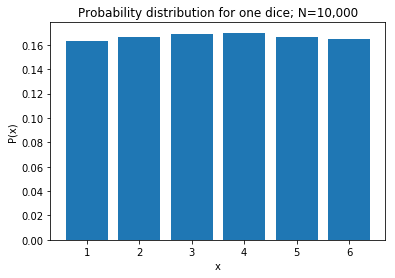

In [24]:
dice = Dice()
sides = [0] * dice.dices * dice.sides
N = 10000
for i in range(N): sides[dice.throw()-1] += 1
sides = np.array(sides) / N
bar(range(1,len(sides)+1), sides);
ylabel('P(x)')
xlabel('x')
title('Probability distribution for one dice; N=10,000');

### Advanced: two dice with six sides

Monopoly is played with two dices. This will give the following probability distribution:

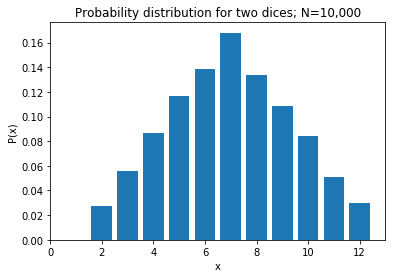

In [25]:
dice = Dice(2)
sides = [0] * dice.dices * dice.sides
N = 10000
for i in range(N): sides[dice.throw()-1] += 1
sides = np.array(sides) / N
bar(range(1,len(sides)+1), sides);
ylabel('P(x)')
xlabel('x')
title('Probability distribution for two dices; N=10,000');

# Simulated model

We are playing a simplified version of Monopoly. We will not keep track of money. There will only be one player. If a player goes to jail, the player can continue immediately on the next turn. We will keep track of the card decks. The game will be played with $2$ dices. We only count when we land on a square. If we are moved to jail for example, the next round will continue from that new position.

## Algorithm

Here we are going to simulate a game for $N$ amount of rounds. The game algorithm is simple:

1. Roll the dices (there are $2$ dices with $6$ squares)
2. Move to the new position
3. Increment the square counter for that position
4. Check and handle go to jail
5. Check and handle community chest
6. Check and handle chance

## Modulo arithmetic for position tracking

We can easily keep track of our position with modulo arithemetic. Let $C$ be our position (or `index`), $d$ the result from throwing the dice, and $n$ the current round. To determine our new position we calculate:

$$ C_{n+1} \equiv C_n+d \pmod{40}$$

The modulo is $40$ because that are the total amount of squares.

## Implementation

Below is the implementation for the Monopoly simulation.

In [26]:
dice = Dice(2)
community_deck = CommunityDeck()
chance_deck = ChanceDeck()

index = 0 # position
total_squares = len(squares_labels)
squares = [0] * total_squares

rounds = 1000000 # N

for i in range(rounds):
    
    # Throw the dice and move our position on the board.
    steps = dice.throw()
    index = (index + steps) % total_squares
    
    # We landed on go to jail.
    if squares_labels[index] is 'gtj': 
        index = squares_labels.index('jail')
    
    # We landed on the community card.
    if squares_labels[index] in ['cc1', 'cc2', 'cc3']:
        card = community_deck.draw_card()
        if card is 'gtg': index = squares_labels.index('start')
        if card is 'gtj': index = squares_labels.index('jail')
        if card is 'gb2': 
            if index >= 2: index -= 2
            if index < 2: index = total_squares-abs(index-2)-1
    
    # We landed on the chance card.
    if squares_labels[index] in ['c1', 'c2', 'c3']:
        card = chance_deck.draw_card()
        if card is 'gtg': index = squares_labels.index('start')
        if card is 'gtj': index = squares_labels.index('jail')
        if card is 'r3': index = squares_labels.index('r3')
        if card is 'gb3':
            if index >= 3: index -= 3
            if index < 3: index = total_squares-abs(index-3)-1
                
    # Update the counter
    squares[index] += 1

It takes around $2.7$ seconds to run a game when $N=1,000,000$. Because there is only one loop the algorithm will scale linearly.

# Probability statistics

Now we can proceed to analyze our results.

## Determining probabilities

With the number of times that each square is visited, and the total rounds $N$ we can calculate the probabilities. The probability that a square is visited is:

$$ P(\bar{x}=x) = \dfrac{\text{Times visited}}{\text{N}} $$

We can calculate the expected value for each square in terms of money with:

$$ E(\bar{k}) = P(\bar{x}=x)\cdot\text{Rent} $$

We also want to create a `DataFrame` in Python to easily keep track of everything.

In [27]:
df = pd.DataFrame(index=range(total_squares))
df['Square'] = squares_labels
df['Description'] = squares_description
df['Purchasable'] = squares_purchasable
df['Rent'] = squares_rent
df['Visited'] = squares
df['Probability'] = df['Visited'] / rounds
df['Aggregate'] = squares_aggregate
df['Expected Value'] = df['Probability'] * df['Rent']

We can calculate a quick summary about the data:

In [28]:
print('Total rounds: {}'.format(rounds))
print('Visited avg:  {}'.format(df['Visited'].mean()))
print('Visited min:  {}'.format(df['Visited'].min()))
print('Visited max:  {}'.format(df['Visited'].max()))
print('Visited std:  {:.2f}'.format(df['Visited'].std()))

Total rounds: 1000000
Visited avg:  25000.0
Visited min:  0
Visited max:  59078
Visited std:  7443.10


## Plot of probabilities by square

If we sort these values descending on the probability, we can easily see which squares have the highest probability to be visited.

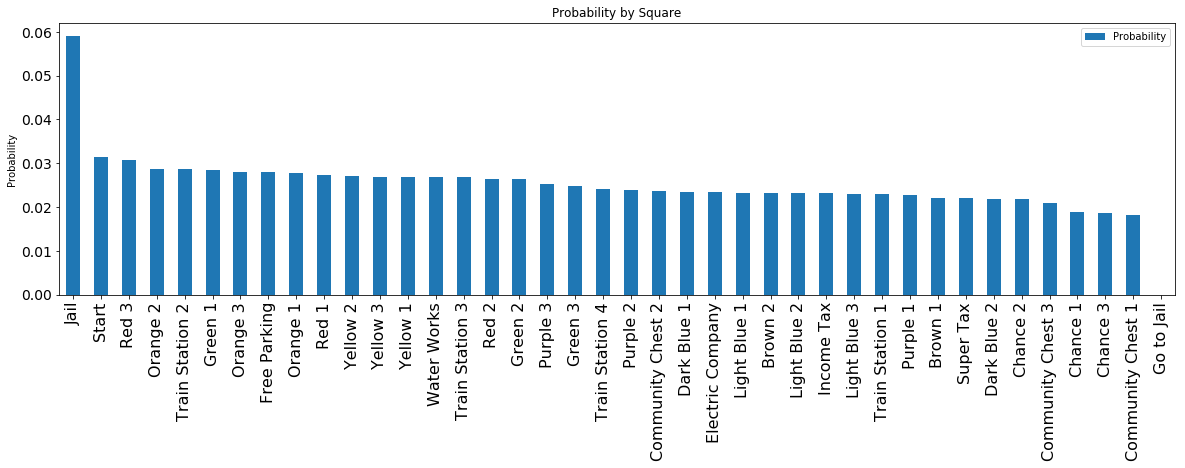

In [29]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=14) 
df[['Description', 'Probability']].sort_values(by='Probability', ascending=False)\
    .plot(kind='bar', figsize=(20,5))
plt.xticks(range(total_squares), df[['Description', 'Probability']]
    .sort_values(by='Probability', ascending=False)['Description'])
plt.ylabel('Probability')
plt.title('Probability by Square');

Here we can conclude that `Orange 1` is the most visited square. Also notice that `Orange 2` and `Orange 3` are pretty high. It seems that `Orange` is the best street to have.

## Table of probabilities by square

Below is the full table with all the squares and their corresponding values.

In [30]:
df.loc[:, df.columns.isin(['Square', 'Description', 'Probability'])].sort_values(by='Probability', ascending=False)

,Square,Description,Probability
10,jail,Jail,0.059078
0,start,Start,0.031421
24,r3,Red 3,0.030681
18,o2,Orange 2,0.028676
15,ts2,Train Station 2,0.028584
31,g1,Green 1,0.028344
19,o3,Orange 3,0.027934
20,p,Free Parking,0.027895
16,o1,Orange 1,0.027742
21,r1,Red 1,0.027343


## Top 10 highest probability squares

The top 10 squares that have the highest probability for a player to land on are:

In [31]:
df.loc[df['Purchasable'] == True, df.columns.isin(['Square', 'Description', 'Probability'])]\
    .sort_values('Probability', ascending=False).head(10)

,Square,Description,Probability
24,r3,Red 3,0.030681
18,o2,Orange 2,0.028676
15,ts2,Train Station 2,0.028584
31,g1,Green 1,0.028344
19,o3,Orange 3,0.027934
16,o1,Orange 1,0.027742
21,r1,Red 1,0.027343
27,y2,Yellow 2,0.027192
29,y3,Yellow 3,0.026966
26,y1,Yellow 1,0.026950


The total probability for all 10 squares is:

In [32]:
df.loc[df['Purchasable'] == True].sort_values('Probability', ascending=False)\
    .head(10)['Probability'].sum()

0.28041199999999999

## Plot of expected value per turn

Now we want to know how much each square generates per turn with the found probabilities and the rent the player needs to pay when we land on it. First we make a selection to only get the purchasable squares. 

In [33]:
rentable_df = pd.DataFrame(df.loc[df['Purchasable'] == True]).reindex()

Plotting this gives:

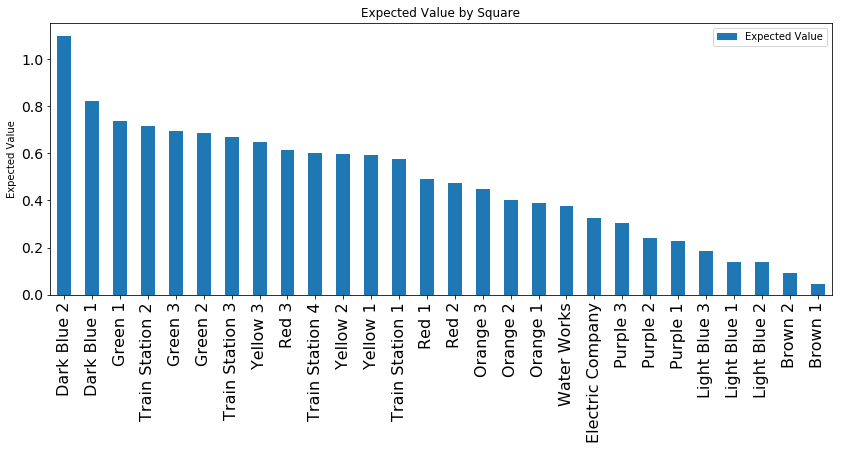

In [34]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=14) 
rentable_df[['Description', 'Expected Value']].sort_values(by='Expected Value', ascending=False)\
    .plot(kind='bar', figsize=(14,5))
plt.xticks(range(len(rentable_df.index)), rentable_df[['Description', 'Expected Value']]
    .sort_values(by='Expected Value', ascending=False)['Description'])
plt.ylabel('Expected Value')
plt.title('Expected Value by Square');

## Table of expected value per turn 

The full table of expected values is below.

In [35]:
rentable_df.loc[:, rentable_df.columns.isin(['Square', 'Description', 'Rent', 'Probability', 'Expected Value'])]\
    .sort_values('Expected Value', ascending=False)

,Square,Description,Rent,Probability,Expected Value
39,db2,Dark Blue 2,50.0,0.021942,1.097100
37,db1,Dark Blue 1,35.0,0.023417,0.819595
31,g1,Green 1,26.0,0.028344,0.736944
15,ts2,Train Station 2,25.0,0.028584,0.714600
34,g3,Green 3,28.0,0.024771,0.693588
32,g2,Green 2,26.0,0.026300,0.683800
25,ts3,Train Station 3,25.0,0.026798,0.669950
29,y3,Yellow 3,24.0,0.026966,0.647184
24,r3,Red 3,20.0,0.030681,0.613620
35,ts4,Train Station 4,25.0,0.024023,0.600575


# Grouped probability statistics

We want to answer the following questions:

1. What are the best streets to have?
2. What is the probability to be in jail?
3. What is the probability to draw a card?

## Plot of probabilities by group

To find what the probabilities are per street, chance, community chest, etc., we are going to aggregate the possibilities.

In [36]:
aggregated_df = pd.DataFrame(df.groupby(['Aggregate'])['Probability'].sum()).reset_index()

Now we plot the aggregated probabilities.

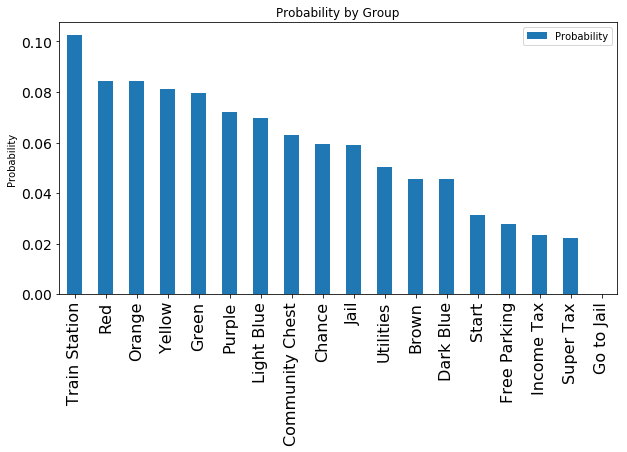

In [37]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=14) 
aggregated_df[['Aggregate', 'Probability']].sort_values(by='Probability', ascending=False)\
    .plot(kind='bar', figsize=(10,5))
plt.xticks(range(len(aggregated_df.index)), aggregated_df[['Aggregate', 'Probability']]
    .sort_values(by='Probability', ascending=False)['Aggregate'])
plt.ylabel('Probability')
plt.title('Probability by Group');

## Table of probabilities by group

A total overview of all the probabilities can be found in the table below:

In [38]:
aggregated_df.sort_values('Probability', ascending=False)

,Aggregate,Probability
15,Train Station,0.102484
12,Red,0.084395
10,Orange,0.084352
17,Yellow,0.081108
6,Green,0.079415
11,Purple,0.071904
9,Light Blue,0.069525
2,Community Chest,0.062793
1,Chance,0.059364
8,Jail,0.059078


## Plot of expected values by group

If we find the expected values by each aggregate we can find out which group generated the most money per turn.

In [39]:
aggregated_ev_df = pd.DataFrame(df.loc[df['Purchasable'] == True]\
    .groupby(['Aggregate'])['Expected Value'].sum()).reset_index()

Plotting this gives:

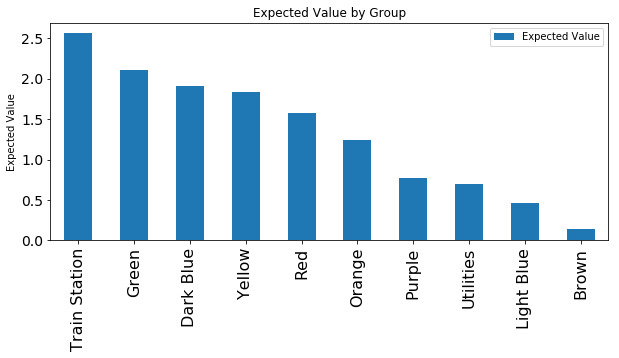

In [40]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=14) 
aggregated_ev_df[['Aggregate', 'Expected Value']].sort_values(by='Expected Value', ascending=False)\
    .plot(kind='bar', figsize=(10,4))
plt.xticks(range(len(aggregated_ev_df.index)), aggregated_ev_df[['Aggregate', 'Expected Value']]
    .sort_values(by='Expected Value', ascending=False)['Aggregate'])
plt.ylabel('Expected Value')
plt.title('Expected Value by Group');

We can conclude that the `Train Station` yields the most. This are however $4$ squares. The best street to have is `Green`.

## Table of expected values by group

A full table of expected values can be found below

In [41]:
aggregated_ev_df.sort_values('Expected Value', ascending=False)

,Aggregate,Expected Value
7,Train Station,2.562100
2,Green,2.114332
1,Dark Blue,1.916695
9,Yellow,1.838308
6,Red,1.580472
4,Orange,1.236796
5,Purple,0.769538
8,Utilities,0.702576
3,Light Blue,0.463308
0,Brown,0.137264


# Other probabilities

## Train station probabilities

We can conclude that `Train Station` has the highest probability to land on. However, we need to take into account that there are four squares to land on.

In [42]:
df.loc[df['Aggregate'] == 'Train Station', df.columns.isin(['Square', 'Description', 'Probability', 'Expected Value'])]\
    .sort_values('Probability', ascending=False)

,Square,Description,Probability,Expected Value
15,ts2,Train Station 2,0.028584,0.714600
25,ts3,Train Station 3,0.026798,0.669950
35,ts4,Train Station 4,0.024023,0.600575
5,t1,Train Station 1,0.023079,0.576975


## Probability to be in jail

To find the total probability to be in jail, we need to take into account that:

 * We can land on jail.
 * We can land on go to jail.
 * There is one community card which sends you to jail.
 * There is one chance card which sends you to jail.
 
Each deck has $16$ cards, therefore the probability to draw go to jail is $P(\bar{x}=\text{go to jail})=\dfrac{1}{16}$.

$$P(\bar{x}=\text{in jail}) = P(\bar{x}=\text{jail}) + P(\bar{x}=\text{go to jail}) + \dfrac{1}{16}\left[ P(\bar{x}=\text{community chest}) + P(\bar{x}=\text{chance})\right] $$

In [43]:
P_jail           = sum(aggregated_df.loc[aggregated_df['Aggregate'] == 'Jail'           ]['Probability'])
P_go_to_jail     = sum(aggregated_df.loc[aggregated_df['Aggregate'] == 'Go to Jail'     ]['Probability'])
P_community_card = sum(aggregated_df.loc[aggregated_df['Aggregate'] == 'Community Chest']['Probability'])
P_chance_card    = sum(aggregated_df.loc[aggregated_df['Aggregate'] == 'Chance'         ]['Probability'])

In [44]:
P_jail + P_go_to_jail + 1/16 * (P_community_card + P_chance_card)

0.066712812499999996

## Probability to draw a card

To find the probability to draw a card, we simply calculate:

$$ P(\bar{x}=\text{draw a card}) = P(\bar{x}=\text{community chest}) + P(\bar{x}=\text{chance})$$

In [45]:
P_community_card + P_chance_card

0.122157

Where the probabilities for the community chest square are:

In [46]:
df.loc[df['Aggregate'] == 'Community Chest', df.columns.isin(['Square', 'Description', 'Probability'])]\
    .sort_values('Probability', ascending=False)

,Square,Description,Probability
17,cc2,Community Chest 2,0.023722
33,cc3,Community Chest 3,0.020822
2,cc1,Community Chest 1,0.018249


And the probabilities for the chance square are:

In [47]:
df.loc[df['Aggregate'] == 'Chance', df.columns.isin(['Square', 'Description', 'Probability'])]\
    .sort_values('Probability', ascending=False)

,Square,Description,Probability
22,c2,Chance 2,0.021792
7,c1,Chance 1,0.018835
36,c3,Chance 3,0.018737


# Markov matrix model

Another way to find the probabilities, would be to create a Markov matrix with the probability to go another square, for each individual square. This will be a $40\times40$ square matrix $M$.

In [56]:
M = np.eye(40)

In [57]:
M

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

Then we need to fill in the matrix. For each square we are going to calculate the probabilities to get on any other square. For the most the probability will be $0$ because we can't throw high enough numbers. We also need to take into the account that there are probabilities that are generated by the cards and add those to the respecting elements.

When we have filled the matrix with all the values we let the matrix converge with $\lim\limits_{n\rightarrow\infty}M^n$. A simple way to approximate this would be to square the matrix a few times, like $M^{64}$. The resulting matrix will have the probabilities for every square.

## Probabilities for throwing two dices

To fill our matrix $M$ we first need to find the probability distribution for two dices.

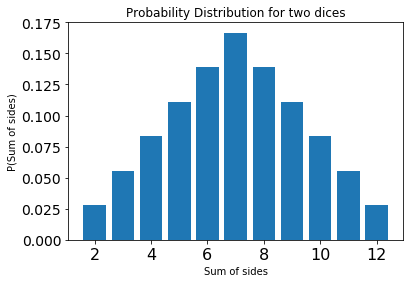

In [58]:
outcomes = [x+y for x in range(1,7) for y in range(1,7)]
probabilities = {}
for o in set(outcomes): probabilities[o] = outcomes.count(o) / len(outcomes)
side, p = probabilities.keys(), probabilities.values()
bar(side, p)
xlabel('Sum of sides')
ylabel('P(Sum of sides)')
title('Probability Distribution for two dices');

The range of values for two dices is:

In [59]:
throw_min = min(side)
throw_max = max(side)
throw_range = throw_max - throw_min
print('Outcomes are min: {}, max: {} and range: {}.'.format(throw_min, throw_max, throw_range))
prob_df = pd.DataFrame()
prob_df['Sum of sides'] = side
prob_df['P(Sum of sides)'] = p

Outcomes are min: 2, max: 12 and range: 10.


## Probabilities for any position

We want to create a matrix row for each tile. We want to calculate the probability to land on another square, calculated for all squares. We also want to use the modulo arithmetic here to wrap our position around the board.

In [60]:
def get_probability_for_throw(n):
    if n < 2 or n > 12: return 0
    return probabilities[n]

def get_probabilities_for_position(pos):
    squares = [0] * 40
    for i in range(40):
        squares[(pos+i)%40] = get_probability_for_throw(i)
    
    # Go to jail
    squares[10] += squares[2] * 1/16  # Go to jail community card 1
    squares[10] += squares[7] * 1/16  # Go to jail chance card 1
    squares[10] += squares[17] * 1/16 # Go to jail community card 2
    squares[10] += squares[22] * 1/16 # Go to jail chance card 2
    squares[10] += squares[33] * 1/16 # Go to jail community card 3
    squares[10] += squares[36] * 1/16 # Go to jail chance card 3
    
    # Go to start
    squares[0] += squares[2] * 1/16   # Go to start community card 1
    squares[0] += squares[7] * 1/16   # Go to start chance card 1
    squares[0] += squares[17] * 1/16  # Go to start community card 2
    squares[0] += squares[22] * 1/16  # Go to start chance card 2
    squares[0] += squares[33] * 1/16  # Go to start community card 3
    squares[0] += squares[36] * 1/16  # Go to start chance card 3

    # Go back 3 (this creates a loophole because you go back to the community
    # chest, and those probabilities need be recalculated again, for which I am too lazy.
    #squares[4]  += squares[7] * 1/16   # Go back 3 chance card 1
    #squares[19] += squares[22] * 1/16 # Go back 3 chance card 2
    #squares[33] += squares[36] * 1/16 # Go back 3 chance card 3
    
    # Go back 2
    squares[0]  += squares[2] * 1/16   # Go back 2 community card 1
    squares[15] += squares[17] * 1/16 # Go back 2 community card 2
    squares[31] += squares[33] * 1/16 # Go back 2 community card 3
    
    # Go to r3
    squares[24] += squares[7] * 1/16   # Go back 3 chance card 1
    squares[24] += squares[22] * 1/16 # Go back 3 chance card 2
    squares[24] += squares[36] * 1/16 # Go back 3 chance card 3   
    
    # Community
    squares[2]  *= 13/16
    squares[17] *= 13/16
    squares[33] *= 13/16
    
    # Chance
    squares[7]  *= 13/16
    squares[22] *= 13/16
    squares[36] *= 13/16
    
    return squares

Now we test to see that we indeed get the probabilities, starting from any square $n$.

In [61]:
get_probabilities_for_position(24)

[0.008680555555555556,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0,
 0.008680555555555556,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0.001736111111111111,
 0,
 0.027777777777777776,
 0.05555555555555555,
 0.08333333333333333,
 0.1111111111111111,
 0.1388888888888889,
 0.1736111111111111,
 0.1388888888888889,
 0.09027777777777778,
 0.08333333333333333,
 0.05555555555555555,
 0.022569444444444444,
 0,
 0,
 0]

The sum of the column should equal $1$.

In [62]:
sum(get_probabilities_for_position(24))

0.99999999999999989

Take into account that our floating point arithmetic has a few rounding errors, the results seems to be correct. Now we are going to generate the probabilities for all the squares.

In [63]:
chances = []
for p in range(40): chances += get_probabilities_for_position(p)

For a $40\times 40$ matrix, we should have $1600$ elements.

In [64]:
len(chances)

1600

## Converging $M$

Next we apply $\lim\limits_{n\rightarrow\infty}M^n$, to converge to the stable situation of that matrix. Because of floating point arithmetic we keep iterating until we run out of our bit space, which is around $M^{64}$. If we plot a heat map for every $M^n$, where $n$ is between $[1,64]$, we get:

In [65]:
from mpl_toolkits.axes_grid1 import Grid

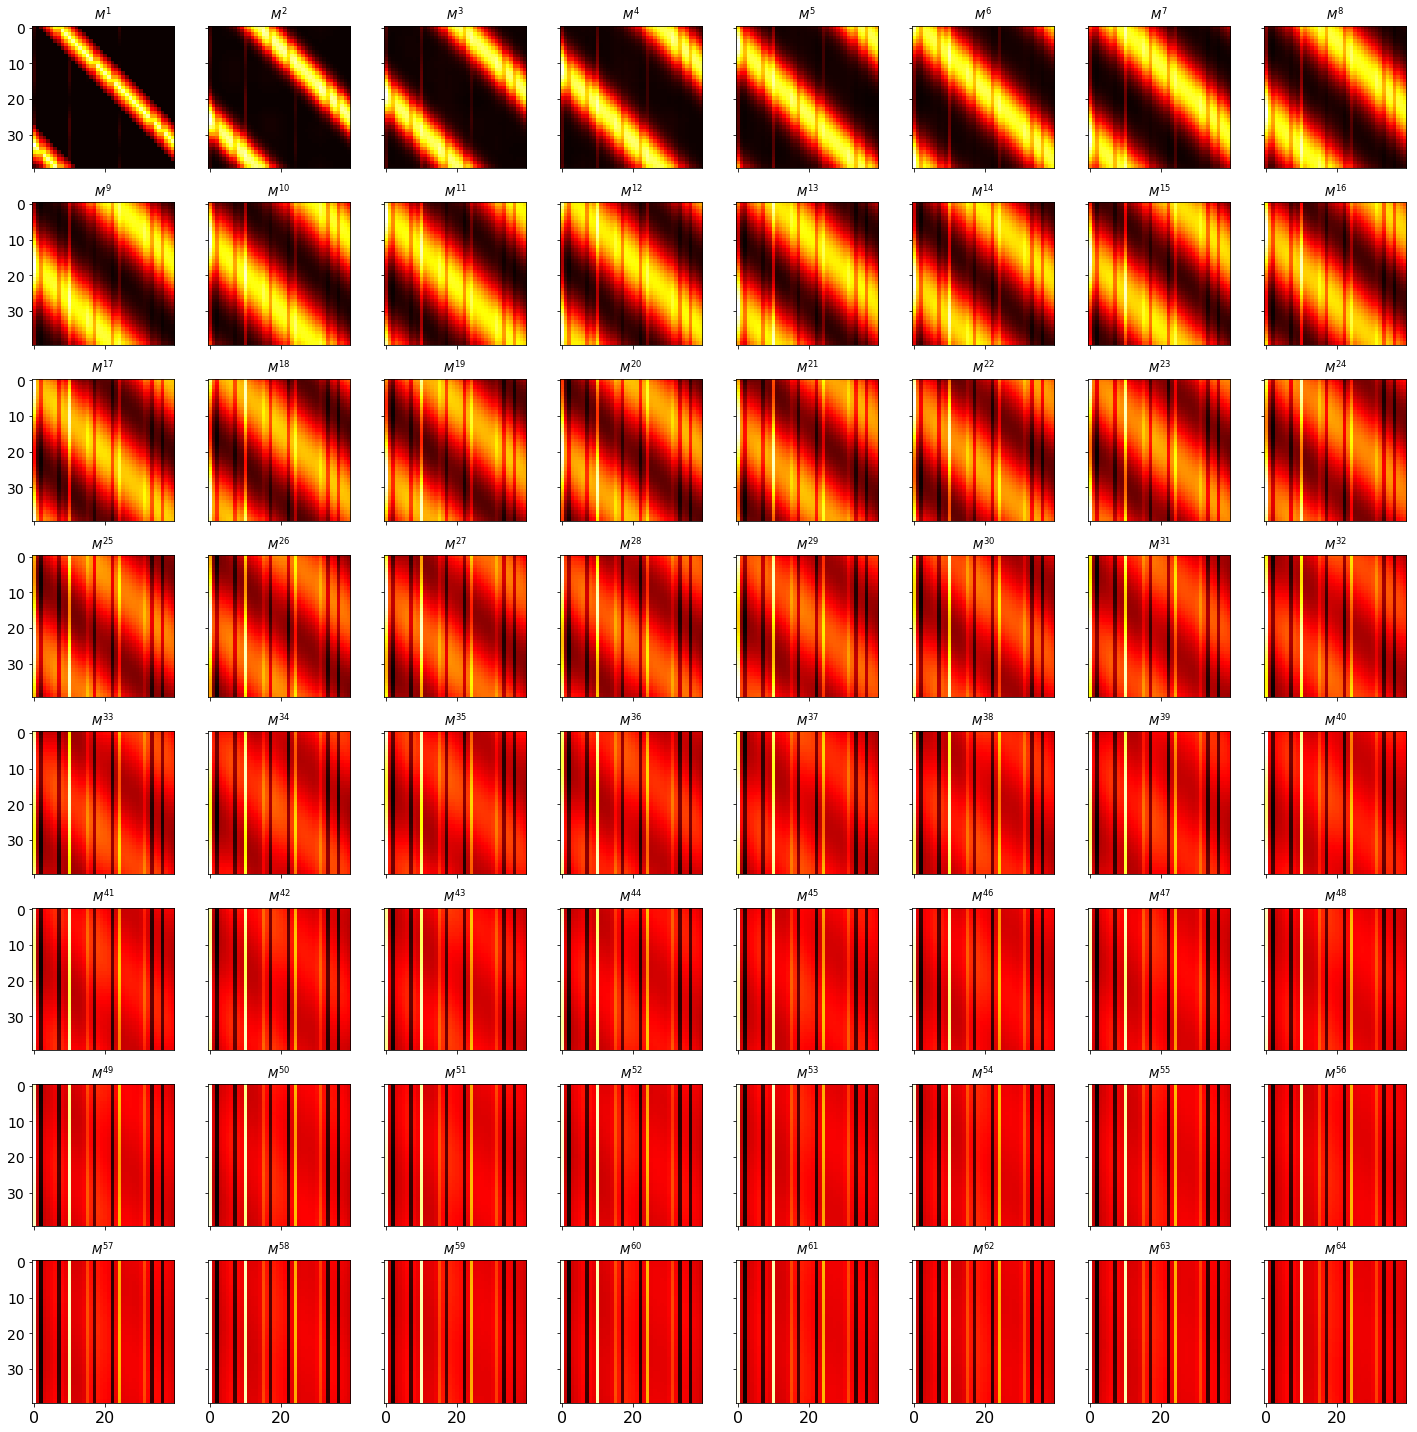

In [66]:
grid = 8
N = grid**2
M = Mn = np.array(chances).reshape(40,40)
plt.figure(figsize=(20,20))

for i in range(N):
    ax = plt.subplot(sqrt(N),sqrt(N),i+1)
    if i < N-sqrt(N): plt.setp(ax.get_xticklabels(), visible=False)
    if i % sqrt(N) != 0: plt.setp(ax.get_yticklabels(), visible=False)
    plt.imshow(Mn, cmap='hot')
    plt.title('$M^{' + str(i+1) + '}$')
    Mn = np.dot(M, Mn)
    
plt.tight_layout()

Which looks quite cool. You can really see how the probabilities spread through the matrix to their exact values. If we look closer at $M^1$ and $M^{64}$:

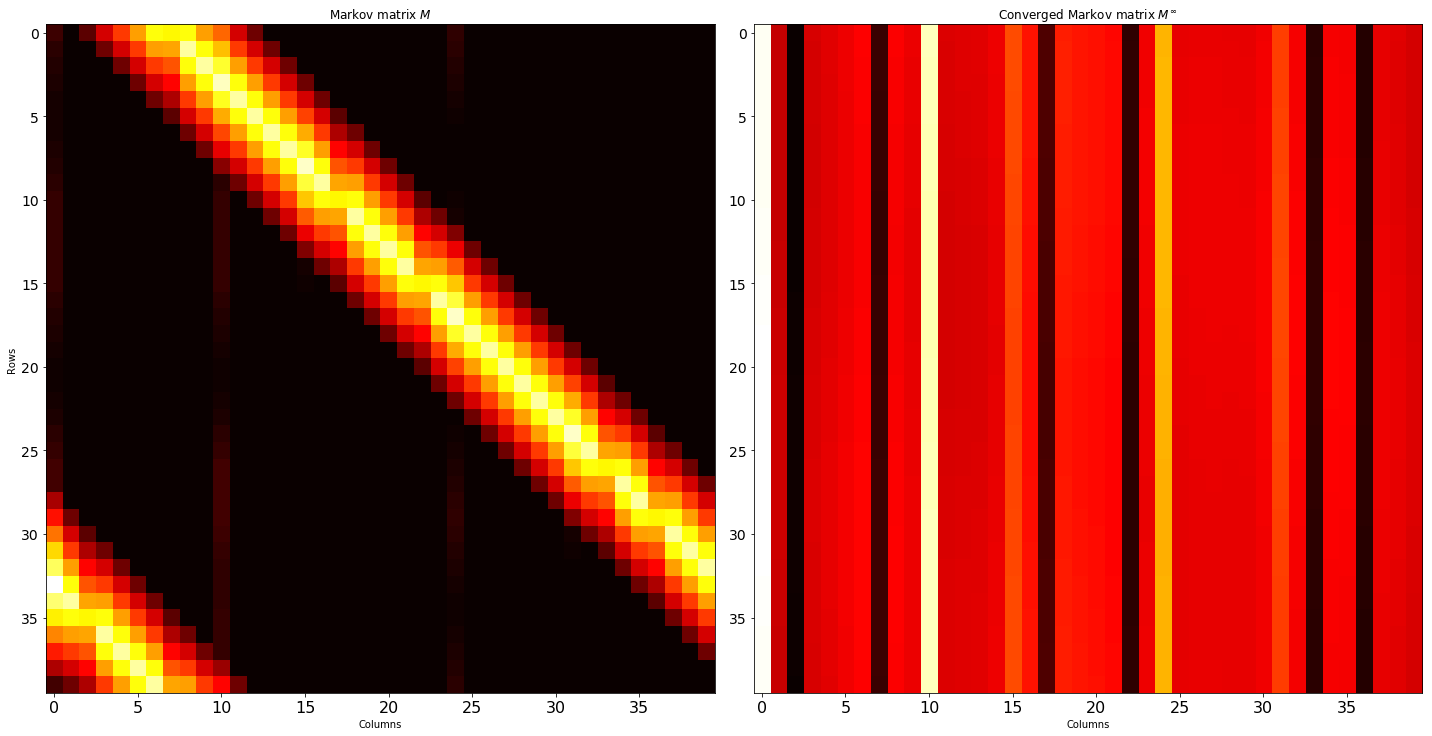

In [67]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(M, cmap='hot')
plt.title('Markov matrix $M$')
plt.ylabel('Rows')
plt.xlabel('Columns')
plt.subplot(1,2,2)
plt.imshow(Mn, cmap='hot')
plt.title('Converged Markov matrix $M^\infty$')
plt.xlabel('Columns')
plt.tight_layout()

Any row from $M$ has the same probability values.

In [68]:
Mn[0,]

array([ 0.03504868,  0.02401996,  0.01968376,  0.0243919 ,  0.0246727 ,
        0.0249952 ,  0.02533011,  0.02077604,  0.02526376,  0.02489455,
        0.03415223,  0.02451821,  0.02460155,  0.02465195,  0.02495032,
        0.02707982,  0.02577487,  0.02124669,  0.02602765,  0.02582802,
        0.02568831,  0.02547366,  0.02054732,  0.02500047,  0.02953957,
        0.02479888,  0.02485625,  0.02485469,  0.024812  ,  0.02479916,
        0.02505142,  0.02676756,  0.02512208,  0.02042048,  0.0251762 ,
        0.02511513,  0.02027001,  0.02479571,  0.02463601,  0.02436713])

If we plot the coefficicients of the first row of $M$:

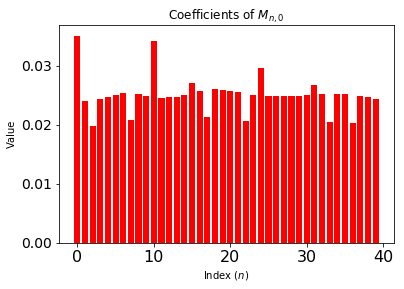

In [69]:
plt.bar(range(len(Mn[0,])), Mn[0,], facecolor='r')
plt.title('Coefficients of $M_{n,0}$')
plt.xlabel('Index ($n$)')
plt.ylabel('Value');

## Error analysis

Finally we add them to a `DataFrame`, and compare our previous results with our new exact results.

 * In our simulation we added the probabilities from `Go to Jail` to `Jail`, so we should also do that for $M$.
 * We removed the `Go back 3` chance card probabilities.

In [70]:
df = pd.DataFrame()
df['Label'] = squares_labels
df['Description'] = squares_description
df['Simulated probabilities'] = squares
df['Simulated probabilities'] /= rounds
df['Converged probabilities'] = Mn[0,]
df.loc[10, 'Converged probabilities'] += df.loc[30, 'Converged probabilities']
df.loc[30, 'Converged probabilities'] = 0
df['Error'] = df['Simulated probabilities'] - df['Converged probabilities']
df['Absolute Error'] = df['Error'].abs()
df['Error percentage'] = df['Absolute Error'] / df['Simulated probabilities']
df

,Label,Description,Simulated probabilities,Converged probabilities,Error,Absolute Error,Error percentage
0,start,Start,0.031421,0.035049,-0.003628,0.003628,0.115454
1,b1,Brown 1,0.022156,0.024020,-0.001864,0.001864,0.084129
2,cc1,Community Chest 1,0.018249,0.019684,-0.001435,0.001435,0.078621
3,b2,Brown 2,0.023238,0.024392,-0.001154,0.001154,0.049656
4,it,Income Tax,0.023191,0.024673,-0.001482,0.001482,0.063891
5,t1,Train Station 1,0.023079,0.024995,-0.001916,0.001916,0.083028
6,lb1,Light Blue 1,0.023246,0.025330,-0.002084,0.002084,0.089655
7,c1,Chance 1,0.018835,0.020776,-0.001941,0.001941,0.103055
8,lb2,Light Blue 2,0.023200,0.025264,-0.002064,0.002064,0.088955
9,lb3,Light Blue 3,0.023079,0.024895,-0.001816,0.001816,0.078667


If we plot a bar chart of the error between our simulated probabilities and our exact probabilities, we get:

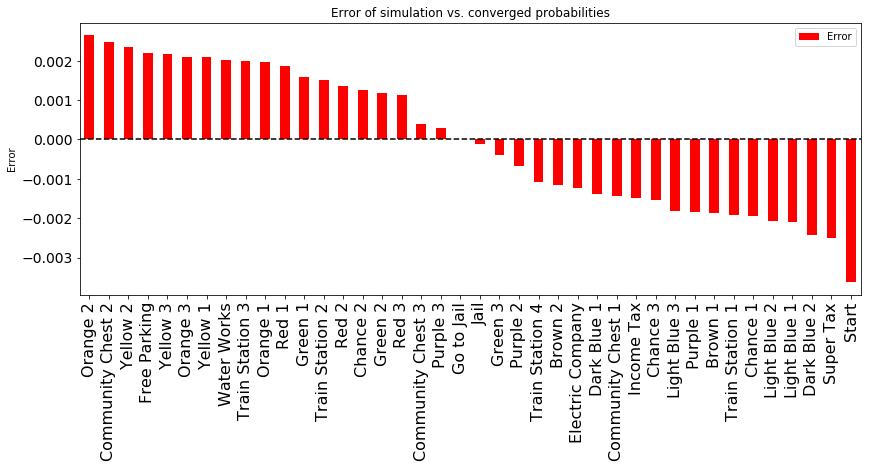

In [71]:
ax = df[['Description', 'Error']].sort_values(by='Error', ascending=False)\
    .plot(kind='bar', figsize=(14,5), facecolor='r')
plt.xticks(range(len(df.index)), df[['Description', 'Error']]
    .sort_values(by='Error', ascending=False)['Description'])
plt.ylabel('Error')
plt.title('Error of simulation vs. converged probabilities')
ax.axhline(0, c='black', ls='dashed');

We can see that the simulation is quite accurate. Calculating the accuracy for the simulated model by subtracting the average error yields:

In [72]:
print('Average accuracy: {:.2f}%'.format((1-df['Error percentage'].mean())*100))

Average accuracy: 93.23%


We should take into consideration that we removed the `Go back 3` from the chance card in both models.